## Configuro notebook

In [20]:
# configuración para notebook con instalación LOCAL
FUENTES_DIR  = '../../Datos-Fuentes/Fuentes/'     # carpeta donde se encuentran archivos .py auxiliares
DATOS_DIR    = '../../Datos-Fuentes/Datos/'      # carpeta donde se encuentran los datasets
MODELOS_DIR  = '../Modelos/'    # carpeta donde se encuentran los modelos
ARCHIVOs_DIR = '../Archivos/'   # carpeta recuperar o copiar archivos

# agrega ruta de busqueda donde tenemos archivos .py
import sys
sys.path.append(FUENTES_DIR)

## Importo librerias

In [21]:
import pandas as pd 
import numpy as np
import chardet
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_curve, classification_report

## Extraigo datos y visualizo

In [22]:
nombre_archivo = DATOS_DIR + 'ecg.csv'

# carga archivo de datos. No tiene fila con titulos!
df= pd.read_csv(nombre_archivo, header=None)

raw_data = df.values
display(df.head())

resultados = df.iloc[:,-1].value_counts(sort=True)
display(resultados)

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


140
1.0    2919
0.0    2079
Name: count, dtype: int64

## Analisis exploratorio de los datos

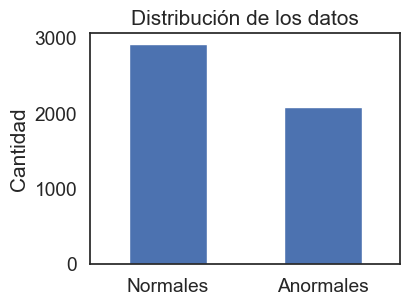

In [23]:
# Cantidad de registros normales vs. fraudulentos
plt.figure(figsize=(4,3))
resultados.plot(kind = 'bar', rot=0)
plt.xticks(range(2), ['Normales', 'Anormales'])
plt.title("Distribución de los datos")
plt.xlabel("")
plt.ylabel("Cantidad")
plt.show()

## Preparo y normalizo datos

In [6]:
# separa en etiquetas y datos
FEAT_CNT = 140


labels = raw_data[:, -1]    # Etiquetas (última columna)
data = raw_data[:, 0:-1]  # Datos (secuencia de 140 lecturas)


labels = labels.astype(int) # ajustas etiquetas porque tiene valores en punto flotante (0.0/1.0)

# separa en datos de entrenamiento y testeo
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=1
)

# Normalización de datos entre 0 y 1. Los datos son lecturas de una señal acotada en intensidad
scaler = MinMaxScaler()

train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

normal_train_data = train_data[train_labels == 1]
normal_test_data = test_data[test_labels == 1]

anomal_train_data = train_data[train_labels == 0]
anomal_test_data = test_data[test_labels == 0]

## Grafico ECG Normal y Anormal

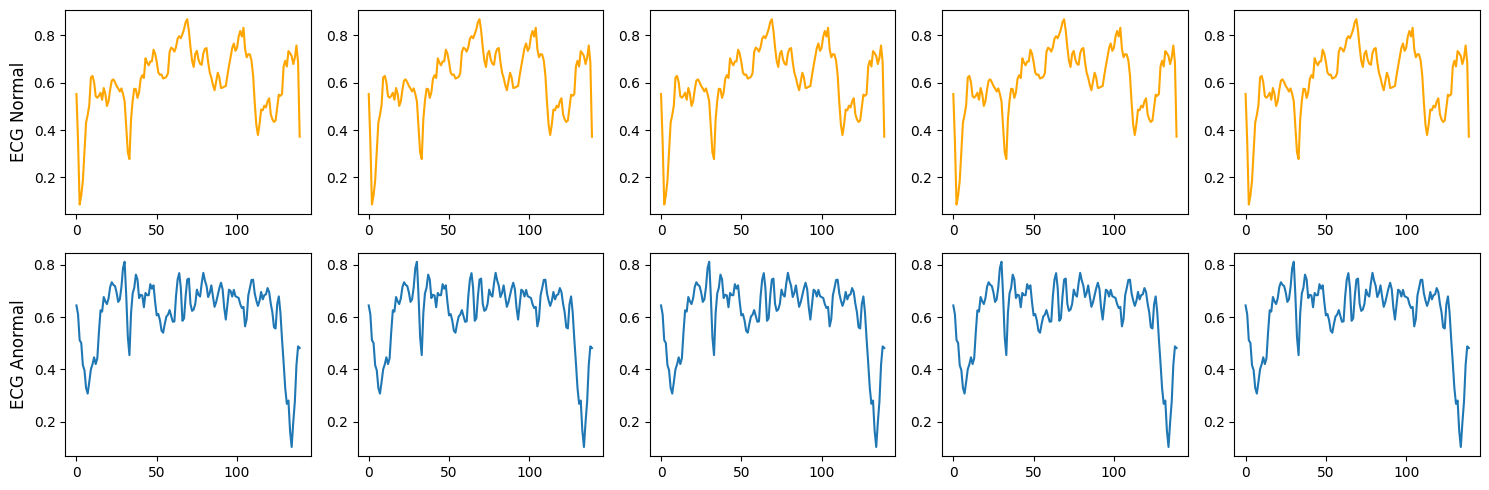

In [7]:
MOSTRAR = 5

fig, axs = plt.subplots(2, MOSTRAR, figsize=(15, 5))  # Ajusta el tamaño de la figura según sea necesario

for i in range(2):
    for j in range(MOSTRAR):
        if i == 0:
            axs[i, j].plot(np.arange(FEAT_CNT), normal_train_data[i], color='orange')  # Cambiar el color de la segunda fila a naranja
        else:
            axs[i, j].plot(np.arange(FEAT_CNT), anomal_train_data[i])  # Gráficos predeterminados para la primera fila

        #axs[i, j].spines['right'].set_visible(False)

# Agregar títulos
axs[0, 0].set_ylabel('ECG Normal' , fontsize=12)
axs[1, 0].set_ylabel('ECG Anormal', fontsize=12)

plt.tight_layout()  # Ajustar automáticamente el espaciado entre subgráficos
plt.show()

## Construyo modelo

In [8]:
# codificador
encoder = tf.keras.Sequential([
    layers.Dense(32, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(8, activation="relu")],
    name = 'Encoder'
    )

# decodificador
decoder = tf.keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(140, activation="sigmoid")],
    name = 'Decoder'
    )

# Modelo completo del autoencoder
# observar como se encadenan la entrada con el codificador y el codificador con el decodificador
inputs = tf.keras.Input(shape=(140,))
encoded = encoder(inputs)
decoded = decoder(encoded)

# Modelo que tiene dos modelos en secuencia
autoencoder = tf.keras.Model(inputs=inputs, outputs=decoded, name = 'Autoencoder')

autoencoder.compile(optimizer='adam', loss='mae')

print(encoder.summary())
print(decoder.summary())
print(autoencoder.summary())


Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                4512      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
Total params: 5,176
Trainable params: 5,176
Non-trainable params: 0
_________________________________________________________________
None
Model: "Decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 16)                144       
                                                                 
 dense_4 (Dense)             (None,

## Entreno

In [9]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = autoencoder.fit(normal_train_data, normal_train_data,
    epochs=200, batch_size=128, validation_data=(test_data, test_data),
    shuffle=True
    )

Epoch 1/200
19/19 [==============================] - 1s 10ms/step - loss: 0.1404 - val_loss: 0.1318
Epoch 2/200
19/19 [==============================] - 0s 4ms/step - loss: 0.1021 - val_loss: 0.0921
Epoch 3/200
19/19 [==============================] - 0s 4ms/step - loss: 0.0610 - val_loss: 0.0787
Epoch 4/200
19/19 [==============================] - 0s 4ms/step - loss: 0.0486 - val_loss: 0.0762
Epoch 5/200
19/19 [==============================] - 0s 4ms/step - loss: 0.0464 - val_loss: 0.0757
Epoch 6/200
19/19 [==============================] - 0s 4ms/step - loss: 0.0458 - val_loss: 0.0756
Epoch 7/200
19/19 [==============================] - 0s 4ms/step - loss: 0.0456 - val_loss: 0.0755
Epoch 8/200
19/19 [==============================] - 0s 4ms/step - loss: 0.0455 - val_loss: 0.0748
Epoch 9/200
19/19 [==============================] - 0s 4ms/step - loss: 0.0452 - val_loss: 0.0745
Epoch 10/200
19/19 [==============================] - 0s 4ms/step - loss: 0.0449 - val_loss: 0.0736
Epoch 11

## Grafico perdida

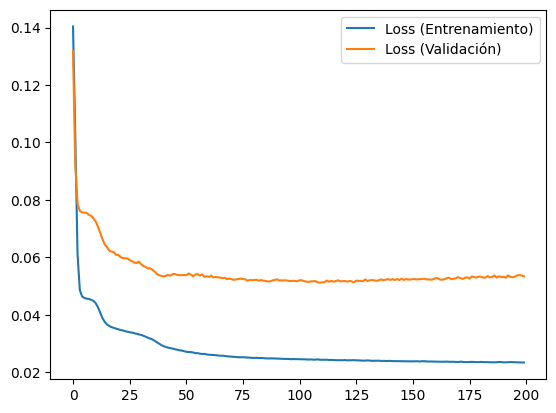

In [10]:
######## plot
plt.figure()
plt.plot(history.history["loss"], label="Loss (Entrenamiento)")
plt.plot(history.history["val_loss"], label="Loss (Validación)")
plt.legend()

## Reconstruyo ECG Normal y Anormal

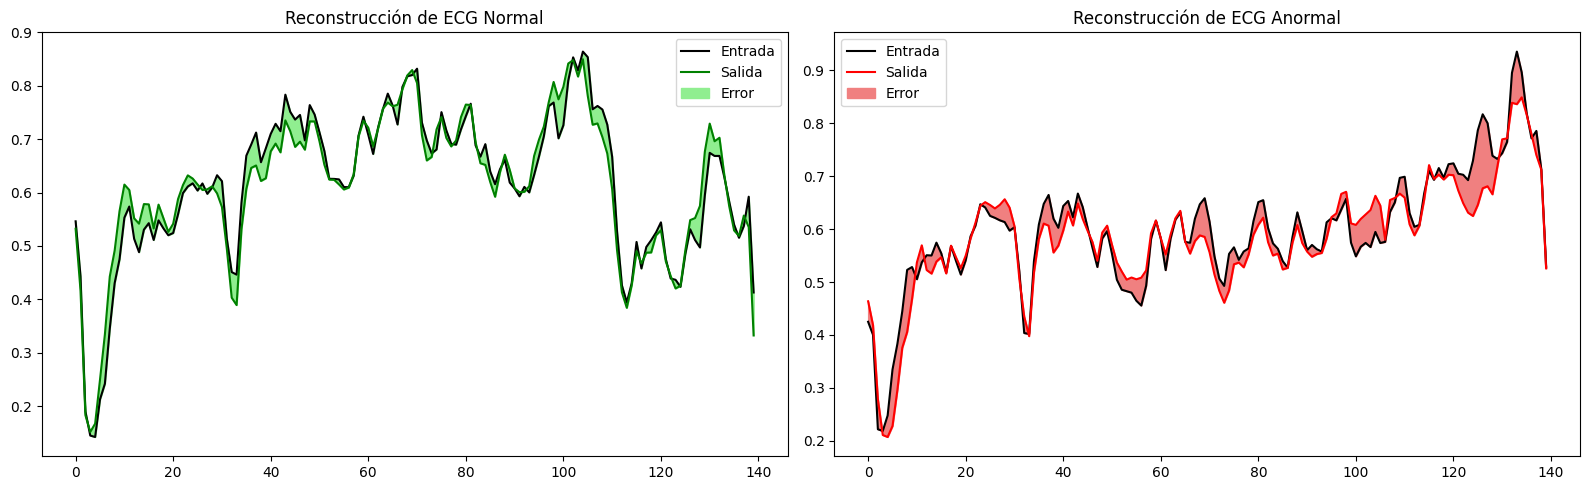

In [11]:
plt.figure(figsize=(16,5))

# Error de reconstrucción para ECG Normal
# decoded_data = autoencoder.predict(normal_test_data) # equivalente a lineas siguientes
encoded_data = encoder(normal_test_data).numpy()  # equivalente a encoded_data = encoder.predict(normal_test_data)
decoded_data = decoder(encoded_data).numpy()      # equivalente a decoded_data = decoder.predict(encoded_data)

plt.subplot(1, 2, 1)
plt.title("Reconstrucción de ECG Normal")
plt.plot(normal_test_data[0], 'black')
plt.plot(decoded_data[0], 'green')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightgreen')
plt.legend(labels=["Entrada", "Salida", "Error"])

# Error de reconstruccion para ECG Anormal
encoded_data = encoder(anomal_test_data).numpy()
decoded_data = decoder(encoded_data).numpy()

plt.subplot(1, 2, 2)
plt.title("Reconstrucción de ECG Anormal")
plt.plot(anomal_test_data[0], 'black')
plt.plot(decoded_data[0], 'red')
plt.fill_between(np.arange(140), decoded_data[0], anomal_test_data[0], color='lightcoral')
plt.legend(labels=["Entrada", "Salida", "Error"])

plt.tight_layout()  # Ajustar automáticamente el espaciado entre subgráficos
plt.show()

## Error de construccion en ECG Normales

73/73 [==============================] - 0s 1ms/step


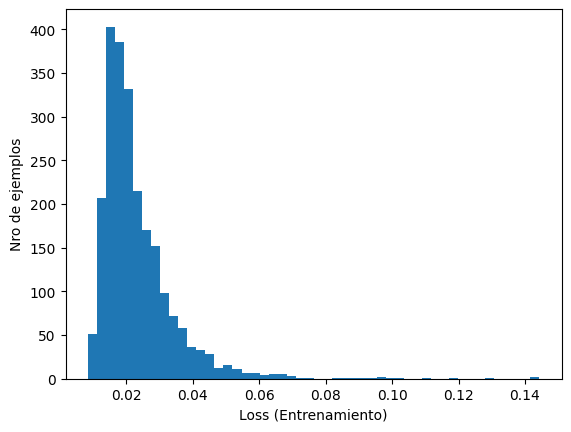

In [12]:
#Trazar el error de reconstrucción en ECG normales del conjunto de entrenamiento
reconstruccion = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstruccion, normal_train_data)

plt.figure()
plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Loss (Entrenamiento)")
plt.ylabel("Nro de ejemplos")
plt.show()

## Error (pérdida) de reconstrucción en ECG anormales del conjunto de prueba

13/13 [==============================] - 0s 865us/step


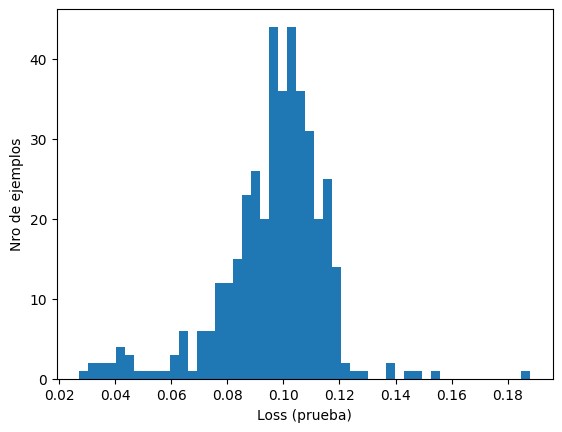

In [13]:
reconstruccion = autoencoder.predict(anomal_test_data)
test_loss = tf.keras.losses.mae(reconstruccion, anomal_test_data)

plt.figure()
plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Loss (prueba)")
plt.ylabel("Nro de ejemplos")
plt.show()


## Predigo y defino umbral

In [15]:
def predict(modelo, datos, umbral):
  reconstruccion = modelo(datos)
  loss = tf.keras.losses.mae(reconstruccion, datos)
  return tf.math.less(loss, umbral)

def print_stats(predicciones, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predicciones)))
  print("Precision = {}".format(precision_score(labels, predicciones)))
  print("Recall = {}".format(recall_score(labels, predicciones)))


# Elija un valor de umbral que sea una desviación estándar por encima de la media.
#threshold = np.mean(train_loss) + np.std(train_loss)
umbral = np.mean(train_loss) + 1.5*np.std(train_loss)
print("Umbral: ", umbral)

# Al examinar el error de reconstrucción de los ejemplos anómalos en el conjunto de prueba, se observa
# que la mayoría tiene un error de reconstrucción mayor que el umbral. Al variar el umbral, puede
# ajustar la "precision" y el "recall".

# evalua los datos de prueba con las reconstrucciones, mide error y aplica umbral
preds = predict(autoencoder, test_data, umbral)
# imprime estadisticas en función del umbral aplicado
print_stats(preds, test_labels)
# Calcular la matriz de confusión
conf_matrix = confusion_matrix(test_labels, preds)  # Asegúrate de que `preds` tenga el mismo tamaño que `test_labels`
print("Matriz de Confusión:\n", conf_matrix)

# Generar el reporte de clasificación
report = classification_report(test_labels, preds)
print("Reporte de Clasificación:\n", report)

Umbral:  0.04085926962572519
Accuracy = 0.949
Precision = 0.9838998211091234
Recall = 0.9290540540540541
Matriz de Confusión:
 [[399   9]
 [ 42 550]]
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.90      0.98      0.94       408
           1       0.98      0.93      0.96       592

    accuracy                           0.95      1000
   macro avg       0.94      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000



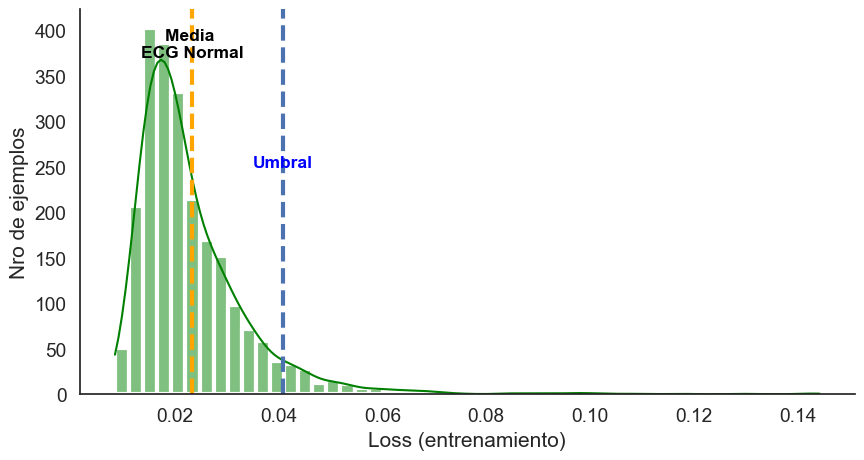

In [16]:
plt.figure(figsize=(10,5))
sns.set(font_scale=1.25)
sns.set_style("white")
sns.histplot(train_loss ,bins=50,kde=True,color='green',linewidth=3)
plt.axvline(x=np.mean(train_loss), color='orange', linestyle='--', linewidth=3)
plt.text(np.mean(train_loss), 370, "Media \nECG Normal", horizontalalignment='center',
         size='small', color='black', weight='semibold')
plt.axvline(x=umbral, color='b', linestyle='--', linewidth=3)
plt.text(umbral, 250, "Umbral", horizontalalignment='center',
         size='small', color='Blue', weight='semibold')
plt.xlabel("Loss (entrenamiento)")
plt.ylabel("Nro de ejemplos")
sns.despine()

13/13 [==============================] - 0s 1ms/step


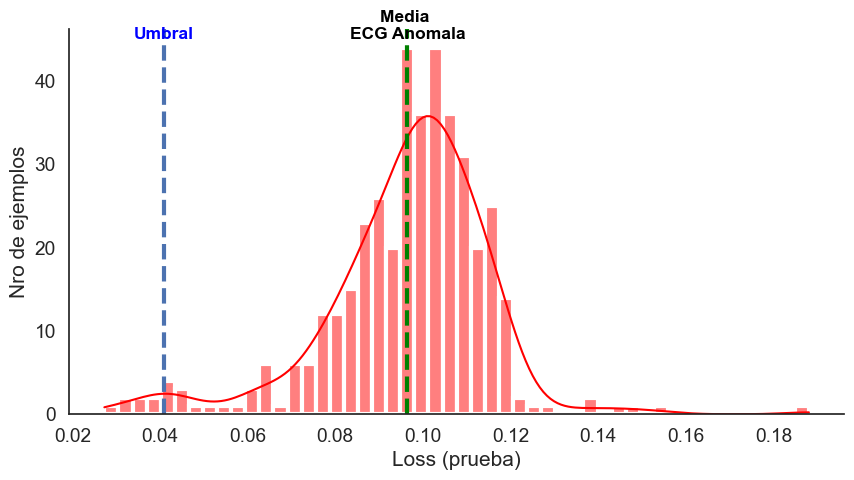

In [17]:
reconstruccion = autoencoder.predict(anomal_test_data)
test_loss = tf.keras.losses.mae(reconstruccion, anomal_test_data)

plt.figure(figsize=(10,5))
sns.set(font_scale = 1.25)
sns.set_style("white")
sns.histplot(test_loss ,bins=50,kde=True,color='red',linewidth=3)
plt.axvline(x=np.mean(test_loss), color='green', linestyle='--', linewidth=3)
plt.text(np.mean(test_loss), 45, "Media \nECG Anomala", horizontalalignment='center',
         size='small', color='black', weight='semibold')
plt.text(umbral, 45, "Umbral", horizontalalignment='center',
         size='small', color='Blue', weight='semibold')
plt.axvline(x=umbral, color='b', linestyle='--', linewidth=3)
plt.xlabel("Loss (prueba)")
plt.ylabel("Nro de ejemplos")
sns.despine()

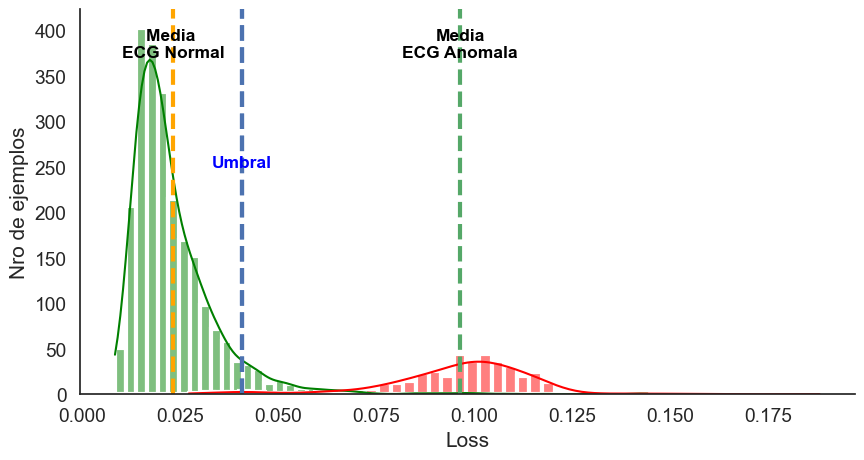

In [18]:
plt.figure(figsize=(10,5))
sns.set(font_scale = 1.25)
sns.set_style("white")
sns.histplot(train_loss ,bins=50,kde=True,color='green',linewidth=3)
plt.axvline(x=np.mean(train_loss), color='orange', linestyle='--', linewidth=3)
plt.text(np.mean(train_loss), 370, "Media \nECG Normal", horizontalalignment='center',
         size='small', color='black', weight='semibold')
plt.axvline(x=umbral, color='b', linestyle='--', linewidth=3)
plt.text(umbral, 250, "Umbral", horizontalalignment='center',
         size='small', color='Blue', weight='semibold')

sns.histplot(test_loss ,bins=50,kde=True,color='red',linewidth=3)
plt.axvline(x=np.mean(test_loss), color='g', linestyle='--', linewidth=3)
plt.text(np.mean(test_loss), 370, "Media\nECG Anomala", horizontalalignment='center',
         size='small', color='black', weight='semibold')
plt.axvline(x=umbral, color='b', linestyle='--', linewidth=3)
plt.xlabel("Loss")
plt.ylabel("Nro de ejemplos")
sns.despine()